In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [112]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

def get_clf_eval(y_test, y_pred=None):
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['T[0]', 'F[1]'], columns = ['pred_T[0]', 'pred_F[1]'])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [113]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx + 1
    series = series.map(my_dict)

    return series

In [160]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("origin_submission.csv") # 테스트 데이터(제출파일의 데이터)

In [161]:
df_all = pd.concat([df_train, df_test])
df_all.shape, df_train.shape, df_test.shape

((64570, 30), (59299, 29), (5271, 30))

### 전처리 baseline

In [162]:
# 열 삭제
drop_col = ['customer_country.1', 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver',
            'product_subcategory', 'product_modelname', 'business_area', 'business_subarea', 'ver_cus', 'ver_pro']

df_all.drop(columns = drop_col, inplace = True)
df_all.isnull().sum()

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       48214
customer_idx                   0
customer_type              45418
enterprise                     0
historical_existing_cnt    49539
customer_job               20172
lead_desc_length               0
inquiry_type                2233
product_category           21232
customer_position              0
response_corporate             0
expected_timeline          33271
ver_win_rate_x             43780
ver_win_ratio_per_bu       47360
lead_owner                     0
is_converted                5271
id                         59299
dtype: int64

In [163]:
# 결측값 0으로 넣을 컬럼
fillna_col = ['com_reg_ver_win_rate', 'historical_existing_cnt',
             'ver_win_rate_x', 'ver_win_ratio_per_bu']

for col in fillna_col:
    df_all[col] = df_all[col].fillna(0)

df_all.isnull().sum()

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate           0
customer_idx                   0
customer_type              45418
enterprise                     0
historical_existing_cnt        0
customer_job               20172
lead_desc_length               0
inquiry_type                2233
product_category           21232
customer_position              0
response_corporate             0
expected_timeline          33271
ver_win_rate_x                 0
ver_win_ratio_per_bu           0
lead_owner                     0
is_converted                5271
id                         59299
dtype: int64

In [164]:
df_all['customer_type'] = df_all['customer_type'].str.lower()
df_all['customer_type'] = df_all['customer_type'].replace(['etc.', 'other', 'others'], 'etc')
df_all['customer_type'] = df_all['customer_type'].replace(['end-customer', 'end customer', 'end-user'], 'end_user')
df_all['customer_type'] = df_all['customer_type'].replace(['specifier/ influencer', 'specifier / influencer'], 'influencer')
df_all['customer_type'] = df_all['customer_type'].replace(['homeowner', 'home owner'], 'home_owner')
df_all['customer_type'] = df_all['customer_type'].replace(['software/solution provider', 'software / solution provider'], 'solution_provider')
df_all['customer_type'] = df_all['customer_type'].replace(['engineer', 'hvac engineer'], 'engineer')
df_all['customer_type'] = df_all['customer_type'].replace(['distributor', 'dealer/distributor'], 'distributor')
df_all['customer_type'].fillna('etc', inplace = True)

In [165]:
# value_counts 가 1개인 것들 etc로 분류
value_counts = df_all['customer_type'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_type'] = df_all['customer_type'].apply(lambda x: 'etc' if x in values_to_replace else x)

In [166]:
df_all['customer_job'].value_counts().head(10)# 일단 대기

customer_job
engineering               7070
other                     4876
administrative            3666
education                 2695
sales                     2380
information technology    2168
operations                2156
purchasing                2118
business development      1965
consulting                1515
Name: count, dtype: int64

In [167]:
df_all['inquiry_type'] = df_all['inquiry_type'].str.lower()
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['etc.', 'other', 'other_', 'others'], 'etc')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['sales inquiry', 'sales', 'probeam precio'], 'sales inquiry')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['quotation or purchase consultation', 'request for quotation or purchase', 'quotation_or_purchase_consultation', 'purchase or quotation', 'quotation_', 'purchase'], 'quotation_or_purchase_consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['usage or technical consultation', 'technical consultation', 'request for technical consulting', 'usage_or_technical_consultation', 'technical_consultation', 'technical'], 'usage or technical consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['vui lòng báo giá giúp mình sản phẩm đo thân nhiệt xin cảm ơn', 'tôi cần tham khảo giá và giải pháp từ lg'], 'quotation_or_purchase_consultation')
df_all['inquiry_type'] = df_all['inquiry_type'].replace(['toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung'], 'product information')

In [168]:
# value_counts 가 1개인 것들 etc로 분류
value_counts = df_all['inquiry_type'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['inquiry_type'] = df_all['inquiry_type'].apply(lambda x: 'etc' if x in values_to_replace else x)

In [169]:
df_all['inquiry_type'].fillna('etc', inplace = True)

In [170]:
# 전처리 필요한 4개 컬럼 간단하게
value_counts = df_all['customer_job'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_job'] = df_all['customer_job'].apply(lambda x: 'other' if x in values_to_replace else x)
df_all['customer_job'].fillna('other', inplace = True)

value_counts = df_all['product_category'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['product_category'] = df_all['product_category'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['product_category'].fillna('etc', inplace = True)

value_counts = df_all['expected_timeline'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['expected_timeline'] = df_all['expected_timeline'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['expected_timeline'].fillna('etc', inplace = True)

value_counts = df_all['customer_country'].value_counts()
values_to_replace = value_counts[value_counts == 1].index
df_all['customer_country'] = df_all['customer_country'].apply(lambda x: 'etc' if x in values_to_replace else x)
df_all['customer_country'].fillna('etc', inplace = True)

In [171]:
df_all.isnull().sum()

bant_submit                    0
customer_country               0
business_unit                  0
com_reg_ver_win_rate           0
customer_idx                   0
customer_type                  0
enterprise                     0
historical_existing_cnt        0
customer_job                   0
lead_desc_length               0
inquiry_type                   0
product_category               0
customer_position              0
response_corporate             0
expected_timeline              0
ver_win_rate_x                 0
ver_win_ratio_per_bu           0
lead_owner                     0
is_converted                5271
id                         59299
dtype: int64

In [172]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [173]:
df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]

In [174]:
df_train.shape, df_test.shape

((59299, 20), (5271, 20))

### 모델링

In [175]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(df_train.drop(["is_converted", 'id'], axis=1), df_train["is_converted"].astype(int))

In [176]:
x_train, x_val, y_train, y_val = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
)

In [177]:
rf_clf = RandomForestClassifier(random_state=42, oob_score = True)
param_grid = {'n_estimators' : np.arange(20, 101, 10),  'max_samples' : [0.8], 
              'max_features' : [0.8], 'criterion' : ["gini", "entropy", "log_loss"],
              'class_weight' : [{0:1, 1:1}]}

grid_rf_clf = GridSearchCV(rf_clf, param_grid, verbose = True, scoring='f1')
grid_rf_clf.fit(x_train, y_train)

print('최적의 파라미터 :', grid_rf_clf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
최적의 파라미터 : {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 80}


In [178]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=80, criterion = 'entropy', 
                                max_features = 0.8, max_samples = 0.8, class_weight = {0: 1, 1:1}, oob_score = True)
rf_clf.fit(x_train, y_train)

y_pred = rf_clf.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = rf_clf.predict(x_test)
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        889         84
F[1]         67        900

정확도: 0.9222
정밀도: 0.9146
재현율: 0.9307
F1: 0.9226


(2071, 5271)

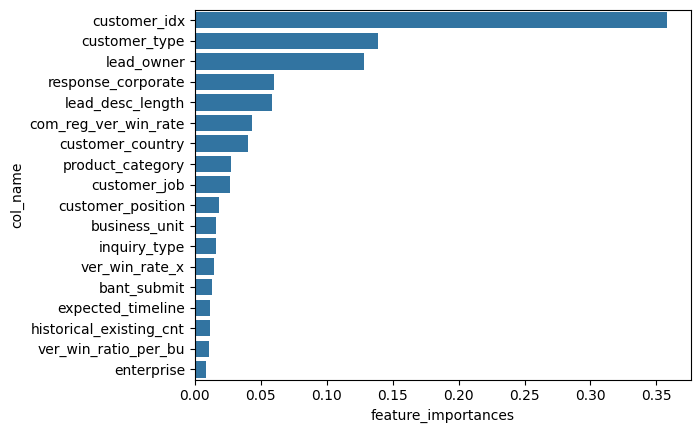

In [179]:
# 변수 중요도
importances = pd.DataFrame(np.mean([tree.feature_importances_ for tree in rf_clf.estimators_], axis = 0))
feature_importances = pd.concat([pd.DataFrame(x_train.columns),importances], axis = 1)
feature_importances.columns = ['col_name', 'feature_importances']
feature_importances = feature_importances.sort_values(by = 'feature_importances', ascending= False).reset_index(drop = True)

# 변수중요도 시각화
sns.barplot(data = feature_importances, y = 'col_name', x = 'feature_importances')
plt.show()

### 여러가지 분류기`

In [192]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

In [182]:
xgb = XGBClassifier(random_state=42)
param_grid = {'n_estimators' : [400, 500, 600, 700], 'learning_rate' : np.arange(0.01, 0.11, 0.02),
             'subsample' : [0.8], 'colsample_bytree' : [0.8]}

grid_xgb = GridSearchCV(xgb, param_grid, verbose = True, scoring='f1')
grid_xgb.fit(x_train, y_train)

print('최적의 파라미터 :', grid_xgb.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
최적의 파라미터 : {'colsample_bytree': 0.8, 'learning_rate': 0.049999999999999996, 'n_estimators': 500, 'subsample': 0.8}


In [201]:
y_pred = grid_xgb.predict(x_val.fillna(0))
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_xgb.predict(x_test.fillna(0))
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        907         66
F[1]         50        917

정확도: 0.9402
정밀도: 0.9329
재현율: 0.9483
F1: 0.9405


(1825, 5271)

In [202]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [184]:
cat = CatBoostClassifier(random_state=42, verbose = False)
param_grid = {'iterations' : [800, 900, 1000, 1100], 'learning_rate' : np.arange(0.05, 0.15, 0.02),
             'subsample' : [0.8], 'colsample_bylevel' : [0.8]}

grid_cat = GridSearchCV(cat, param_grid, verbose = True, scoring='f1')
grid_cat.fit(x_train.fillna(0), y_train.astype(int))

print('최적의 파라미터 :', grid_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
최적의 파라미터 : {'colsample_bylevel': 0.8, 'iterations': 900, 'learning_rate': 0.09000000000000001, 'subsample': 0.8}


In [186]:
y_pred = grid_cat.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_cat.predict(x_test)
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        904         69
F[1]         48        919

정확도: 0.9397
정밀도: 0.9302
재현율: 0.9504
F1: 0.9402


(1814, 5271)

In [188]:
lgbm = LGBMClassifier(random_state = 42, verbose = 0)
param_grid = {'learning_rate': np.arange(0.07, 0.14, 0.02), 'n_estimators': [100, 200, 300, 400, 500],
              'colsample_bytree': [0.8],'subsample': [0.8]}

grid_lgbm = GridSearchCV(lgbm, param_grid, verbose = True, scoring='f1')
grid_lgbm.fit(x_train, y_train)

print('최적의 파라미터 :', grid_lgbm.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
최적의 파라미터 : {'colsample_bytree': 0.8, 'learning_rate': 0.11000000000000001, 'n_estimators': 300, 'subsample': 0.8}


In [190]:
y_pred = grid_lgbm.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = grid_lgbm.predict(x_test)
sum(test_pred), len(test_pred) # True로 예측된 개수

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        909         64
F[1]         50        917

정확도: 0.9412
정밀도: 0.9348
재현율: 0.9483
F1: 0.9415


(1908, 5271)

In [194]:
from sklearn.ensemble import VotingClassifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=80, criterion = 'entropy', 
                                max_features = 0.8, max_samples = 0.8, class_weight = {0: 1, 1:1}, oob_score = True)
rf_clf.fit(x_train, y_train)

xgb = XGBClassifier(random_state=42, colsample_bytree = 0.8, 
                    learning_rate = 0.05, n_estimators = 450, subsample = 0.8)
xgb.fit(x_train, y_train)

cat = CatBoostClassifier(random_state=42, verbose = False, colsample_bylevel = 0.8, 
                         iterations = 900, learning_rate = 0.09, subsample = 0.8)
cat.fit(x_train, y_train.astype(int))

lgbm = LGBMClassifier(random_state = 42, verbose = 0, colsample_bytree = 0.8,
                      learning_rate = 0.11, n_estimators = 300, subsample = 0.8)
lgbm.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.11, n_estimators=300,
               random_state=42, subsample=0.8, verbose=0)

In [195]:
vote = VotingClassifier(estimators= [('xgb',xgb), ('rf_clf', rf_clf), ('cat', cat), ('lgbm', lgbm)], voting= 'soft')
vote.fit(x_train, y_train)

y_pred = vote.predict(x_val)
get_clf_eval(y_val, y_pred)

x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pred = vote.predict(x_test)
sum(test_pred), len(test_pred)

오차행렬:
       pred_T[0]  pred_F[1]
T[0]        910         63
F[1]         53        914

정확도: 0.9402
정밀도: 0.9355
재현율: 0.9452
F1: 0.9403


(1906, 5271)